In [1]:
# Install dependencies.
!pip install -qq --upgrade transformers accelerate diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.8 MB/s eta 0:00:00


In [2]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL, KDPM2AncestralDiscreteScheduler

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

base2 = StableDiffusionXLImg2ImgPipeline(**base.components)

_ = base.to("cuda")
_ = base2.to("cuda")

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

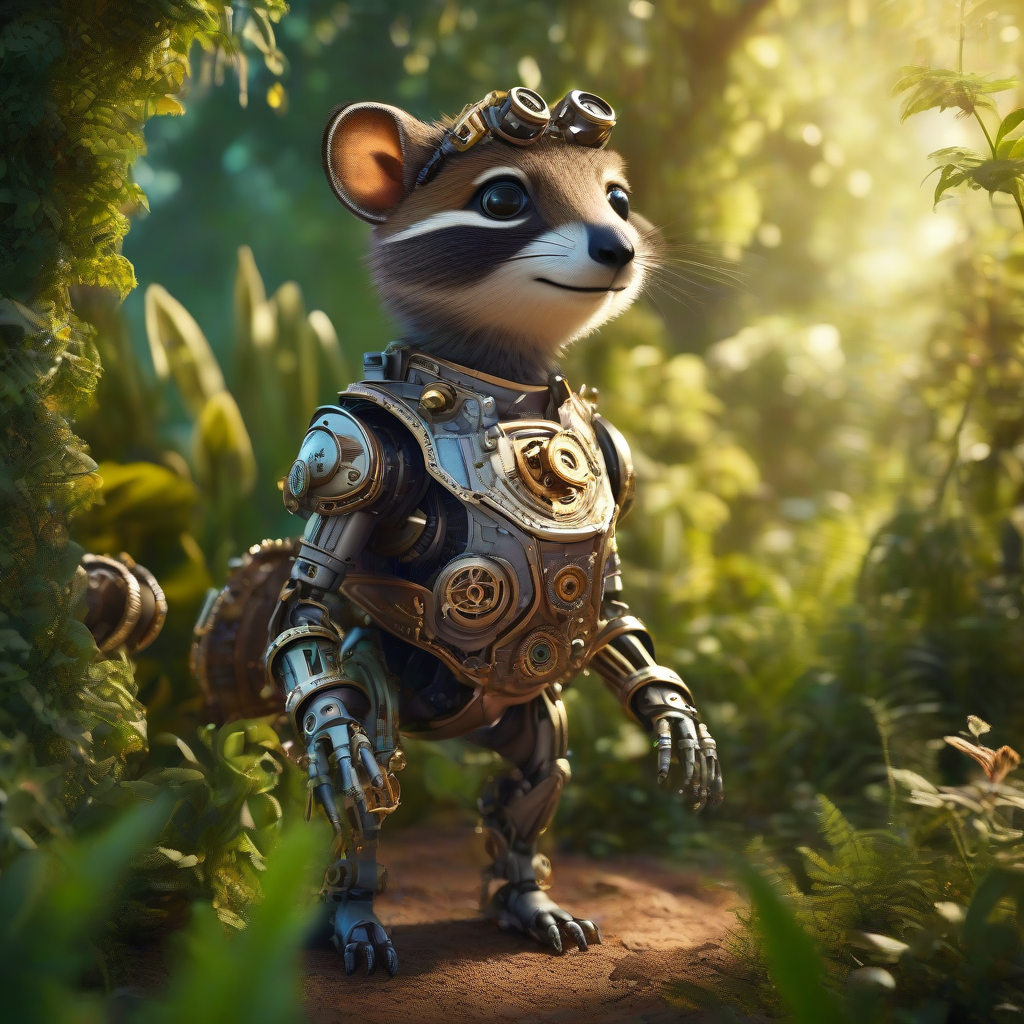

In [ ]:
import os
import zipfile
import random

prompt = f"Steampunk photo of antropomorphic (suricata), pixar, cute, in gray mecha armor looking happy, daylight lush nature park background. Intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"
negative_prompt = "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_samples = 1
guidance_scale = 8
num_inference_steps = 20
height = 1024
width = 1024

prompt = prompt

active_latent = None

latents = base(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(2222),
    output_type = "latent",
    denoising_end = 1/20
).images



for image in images:
  display(image)

  0%|          | 0/20 [00:00<?, ?it/s]

scaling 8.125


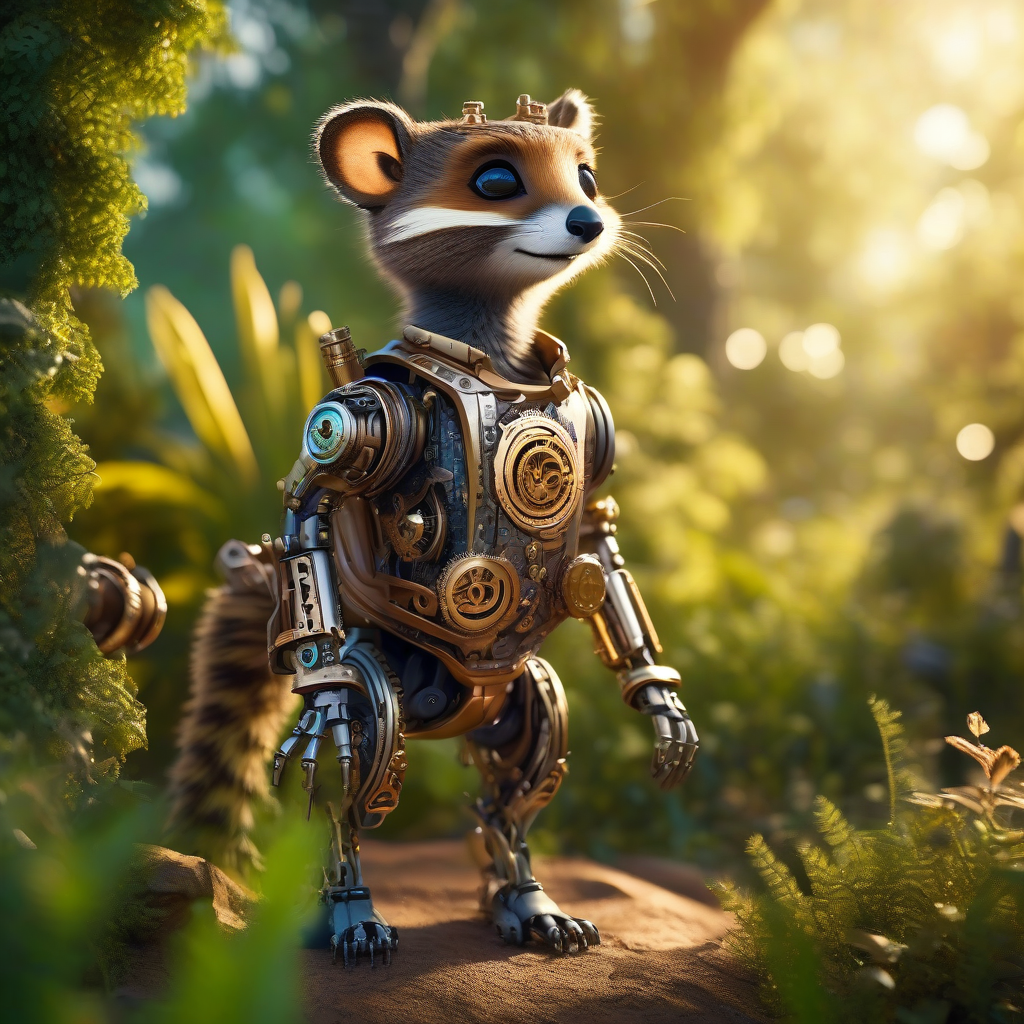

In [ ]:
import diffusers

def model(pipeline, model_type):
        if hasattr(diffusers, pipeline):
            model_class = getattr(diffusers, pipeline)
            return model_class(**base.components)
        else:
            raise ValueError(f"Pipeline '{pipeline}' does not exist in Diffusers")
@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50):
    scaling = 5 + saturation / 16
    print("scaling", scaling)
    samples = vae.decode(latents * scaling).sample
    samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1).cpu()
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).numpy())

def run_inference(pipeline, model_type, instructions):
    global num_inference_steps
    num_inference_steps = instructions['num_inference_steps'] = instructions.get('num_inference_steps', 20)

    seed = random.randint(1, 2147483647) if instructions.get('seed', 0) == 0 else instructions['seed']
    saturation = instructions.get('saturation', 50)
    brightness = instructions.get('brightness', 50)
    contrast = instructions.get('contrast', 50)

    parameters = {
        key: instructions[key]
        for key in instructions
        if key not in [
            'seed',
            'saturation',
            'brightness',
            'contrast'
        ]
    }

    parameters['generator'] = torch.manual_seed(seed)
    parameters['output_type'] = 'latent'

    pipe = model(pipeline, model_type).to('cuda')

    latents = pipe(**parameters).images

    images = decode_latents(latents, saturation, contrast, brightness)

    for index, image in enumerate(images):
        display(image)

    pipe = None
    torch.cuda.empty_cache()

instructions = {
    "prompt": f"Steampunk photo of antropomorphic (suricata), pixar, cute, in (gray) mecha armor looking happy, daylight lush nature park background. intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k",
    "seed": 2222,
    "negative_prompt": "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands",
    "guidance_scale": 9
}

run_inference("StableDiffusionXLPipeline", "base", instructions)